In [1]:
# load libs
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.viz import set_3d_title, set_3d_view
from scipy.linalg import svd
#sns.set_theme() # set the plotting atmosphere

In [2]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\eegClean' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[0]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 1
Current WD: C:\plimon\LTP_analysis\eegClean\ProcessedData_20240415_133053.pkl
Does File #1 Exist? True


### Set Topo Montage For plotting topos

In [3]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


### Function(s)

In [4]:
def contrastAvg(arrIn,s, e):
    """Average Data for low and high contrasts across all subjects"""
    avgCont = {}
    SortedData = {}
    for i in range(2):
        avgCont[i] = np.nanmean(arrIn[s[i]:e[i],:],axis = 0)
        SortedData[i] = arrIn[s[i]:e[i],:]
    return avgCont,SortedData

def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes.axis('off')
    axes.gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    axes.set_title(f'{title_In}', fontsize = 20)
    return fig, axes

In [5]:
# global params / exp condition standards
NumBins = 6    # Number of bins
NumChans = 128 # Number of channels 
NumHarms = 4   # number of harmonics

#### Occipital Channel Info

In [6]:
elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]

AnalysisChans = [elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner]

ExportChans = np.unique(np.sort(np.concatenate(AnalysisChans))) # Combine array for chans of interest
VisChans  = ExportChans - 1
print(f'Channels to be visualized: {VisChans}')

Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


#### Occipital Channel Bool

In [7]:
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)
#print(ocm_chans)

#### Load Data From all Particpants

In [8]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())

dict_keys(['F1_Data', 'F2_Data', 'eegSubInfo'])


In [9]:
# est. keys 
f1 = loadData['F1_Data']
f2 = loadData['F2_Data']
eegSubInf = loadData['eegSubInfo']

In [10]:
print(f1.keys()) # see keys

dict_keys(['BinDiffArith', 'BinBaseDiff', 'BinPrePost'])


#### Bools for Exp Condition Grouping

In [11]:
ai = eegSubInf['attnX_binarybool'] # 1 == attnL , 0 == attnR task
attn_index = np.array(ai)

al = eegSubInf['attnX_label'] # actual label of file expt 
attnX_label = np.array(al)

s_iters = int(len(attn_index)) # total number of particpants 
s_attnl = int(np.sum(attn_index == 1)) # total number of attnl particpants 
s_attnr = int(np.sum(attn_index == 0)) # total number of attnR participants
print(s_attnl,s_attnr)

26 24


In [12]:
f1_bda = f1['BinDiffArith'] # 6 x 128
f2_bda = f2['BinDiffArith']

In [13]:
harmonicofInt = 0 # 2f , 4f, 6f, 8f 
### preallocate for seperating data
attnL_data_f1 =  np.zeros((NumBins,NumChans,s_attnl))
attnR_data_f1 = np.zeros((NumBins,NumChans,s_attnl))

attnL_data_f2 =  np.zeros((NumBins,NumChans,s_attnl))
attnR_data_f2 = np.zeros((NumBins,NumChans,s_attnl))

In [14]:
l_counter = 0
r_counter = 0

for s in range((s_iters)-1):
    dIn_f1 = f1_bda[s][harmonicofInt] # impot 1 subj data and a specific harmonic of interest 
    dIn_f2 = f2_bda[s][harmonicofInt] # import 1 subj data and a specific harmonic of interest 
    
    if attn_index[s] == 1:
        attnL_data_f1[:,:,l_counter] = dIn_f1
        attnL_data_f2[:,:,l_counter] = dIn_f2

        l_counter  = l_counter + 1

    else:
        attnR_data_f1[:,:,r_counter] = dIn_f1
        attnR_data_f2[:,:,r_counter] = dIn_f2

        r_counter = r_counter + 1

In [15]:
f1_attnL = np.nanmean(attnL_data_f1,axis = 2) # contrast x channels 
f1_attnR = np.nanmean(attnR_data_f1,axis = 2) # contrast x channels 

f2_attnL = np.nanmean(attnL_data_f2,axis = 2)
f2_attnR = np.nanmean(attnR_data_f2,axis = 2)

#### Average Data per high and low contrasts

In [16]:
f1L_cont,f1l_all = contrastAvg(arrIn = f1_attnL,s =[0,4],e = [4,5]) # 0 = lo contrasts, 1 = high contrasts
f1R_cont,f1r_all  = contrastAvg(arrIn = f1_attnR,s =[0,4],e = [4,5])

f2L_cont,f2l_all = contrastAvg(arrIn = f2_attnL,s =[0,4],e = [4,5])
f2R_cont,f2r_all  = contrastAvg(arrIn = f2_attnR,s =[0,4],e = [4,5])

(1, 128)
True
True
0.0002305362622580625
0.0002305362622580625


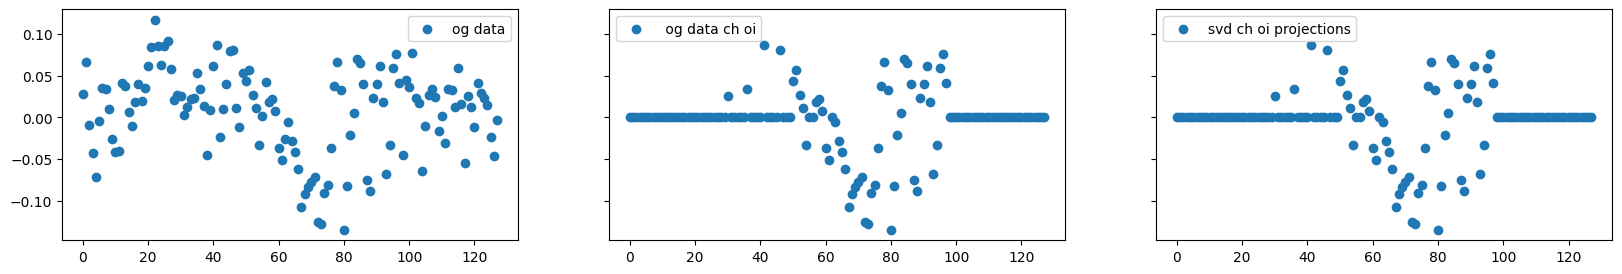

In [17]:
hi_lo = 1
contrast_groups = [f1l_all[hi_lo],f1r_all[hi_lo],f2l_all[hi_lo],f2r_all[hi_lo]] # array of condition data 

gInd = np.array(contrast_groups[0]) #plot 1 group only 
print(gInd.shape)
# svd compu
U,D,Vh = np.linalg.svd(gInd, full_matrices=False) # dim reduction
print(np.allclose(gInd, np.dot(U * D, Vh))) # sanity check of data
smat = np.diag(D) # digonal matrix of weights .... double check this
print(np.allclose(gInd, np.dot(U,np.dot(smat, Vh)))) # futher confirm if svd output is similar enough to og data 
# svd output 
gOut = np.dot(U,np.dot(smat, Vh)) # group data reduction from SVD

# sience out channel activity from channels not of interest
gom = np.array(np.nanmean(gOut[0:1,:], axis = 0)) # average channel weights (?)
misc_chan_avg_svd = np.nanmean(gom[~ocm_chans]/np.sum([ocm_chans == False])) # avg activity of all channels not of interest and spread signal
print(misc_chan_avg_svd)

misc_chan_avg = np.nanmean(f1L_cont[1][~ocm_chans]/np.sum([ocm_chans == False]))
print(misc_chan_avg)
###########################################################################################################################################
# svd channel data
topoIn = gOut[0,:] # 128 channels 
# originl data to spread chan act
mod = f1L_cont[1].copy()
############################################################################################################################################
# spread signal for channels not of interest
topoIn[~ocm_chans] = misc_chan_avg_svd
mod[~ocm_chans] = misc_chan_avg
# compare topo data between: svd, regular signal silencing, and raw data

fig,axs = plt.subplots(1,3, figsize = (20,3), sharey = True) # orignal data with preserved signal 
axs[0].scatter(ch_list,f1L_cont[1], label = f'og data')
axs[0].legend()
# original data with non chans of interest averaged
axs[1].scatter(ch_list,mod, label = f' og data ch oi')
axs[1].legend(loc = 'upper left')
#  svd data with non chans of interest averaged
axs[2].scatter(ch_list,topoIn, label = f'svd ch oi projections')
axs[2].legend(loc = 'upper left')
# plt.scatter

In [18]:
# chans = ch_list[ocm == True]
# print(chans)
SortChanActivityAcs = (np.argsort(np.nanmean(gOut,axis = 0)))
MaxChanActivity = SortChanActivityAcs[0:30]
print(MaxChanActivity)

[ 80  73  72  67  68  74  88  69  81  75  70  87  71  93  66  61  65  60
  76  54  94  64  82  63 102 125 124  62 126 123]


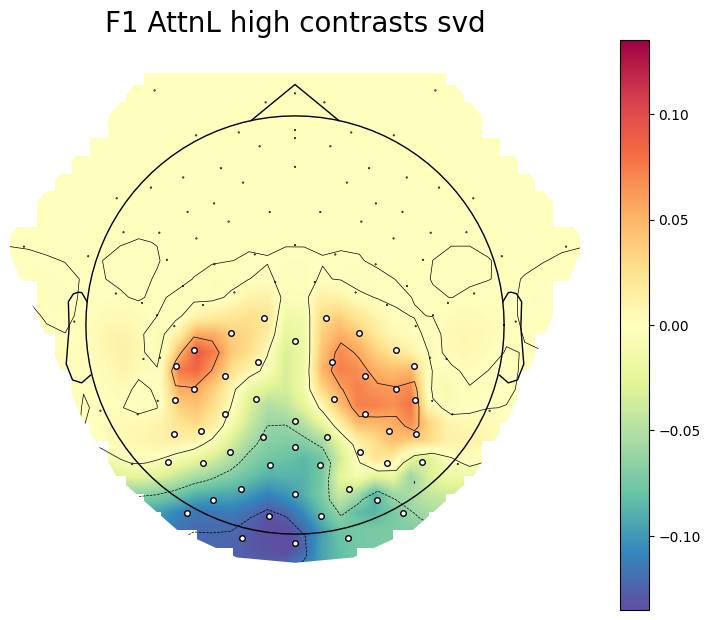

In [19]:
fig,axes = init_TopoTemplate(title_In = 'F1 AttnL high contrasts svd')

im,_ = plot_topomap(topoIn, info, mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =3,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),gridspec_kw=dict(height_ratios=[3]), layout = 'constrained')
axes.set_title(f'F1 AttnL low contrasts svd', fontsize = 14)
axes.axis('off')

im,_ = plot_topomap(topoIn, info, mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10,3), sharey = True)

axs[0].scatter(ch_list,f1L_cont[0], label = f'low contrasts') # original data 
axs[1].scatter(ch_list,f1L_cont[1], label = f'high contrasts') # original data 
axs[0].legend()
axs[1].legend()

In [ ]:
## quick svd idea
dIn = np.array(f1_attnL[0:4,:]) # 4 x 128
U,D,Vh = np.linalg.svd(dIn, full_matrices=False)
print(U.shape) # bin x bin
print(D.shape) # 4 
print(Vh.shape) # chan x chan matrix
# test to make sure SVD was successful
np.allclose(dIn, np.dot(U * D, Vh))
smat = np.diag(D)
np.allclose(dIn, np.dot(U,np.dot(smat, Vh)))

test =  np.dot(U,np.dot(smat, Vh))
print(test.shape)

misc_chan_avg = np.nanmean(test[0,:][~ocm_chans]/np.sum([ocm_chans == False]))
print(misc_chan_avg)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),gridspec_kw=dict(height_ratios=[4]), layout = 'constrained')
axes.set_title(f'F1 AttnL, Bin # {(i+1)}', fontsize = 14)
axes.axis('off')

dataIn = test[0,:]#f1L_cont[0]# plot data per bin-
print(dataIn.shape)
# hashtag below to plot all channel activity
dataIn[~ocm_chans] = misc_chan_avg#misc_chan_avg # want to index good channels only and set the rest channels to 0 value
#im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
im,_ = plot_topomap(dataIn, info, mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
divider = make_axes_locatable(axes)

cax = divider.append_axes('right', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax)
plt.show()


In [ ]:
# for i in range(4):
#     plt.plot(U[i,:], label = f'iter {i}')
# plt.legend()
# plt.plot(D)
# print(D)
#plt.scatter(ch_list,Vh[0,:])

In [ ]:
plt.scatter(ch_list,test[0,:])

In [ ]:
misc_chan_avg = np.nanmean(test[0,:][~ocm_chans]/np.sum([ocm_chans == False]))
print(misc_chan_avg)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),gridspec_kw=dict(height_ratios=[4]), layout = 'constrained')
axes.set_title(f'F1 AttnL, Bin # {(i+1)}', fontsize = 14)
axes.axis('off')

dataIn = test[0,:]#f1L_cont[0]# plot data per bin-
print(dataIn.shape)
# hashtag below to plot all channel activity
dataIn[~ocm_chans] = misc_chan_avg#misc_chan_avg # want to index good channels only and set the rest channels to 0 value
#im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
im,_ = plot_topomap(dataIn, info, mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
divider = make_axes_locatable(axes)

cax = divider.append_axes('right', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),gridspec_kw=dict(height_ratios=[4]), layout = 'constrained')
axes.set_title(f'F1 AttnL, Bin # {(i+1)}', fontsize = 14)
axes.axis('off')

dataIn = f1L_cont[0]# plot data per bin-
print(dataIn.shape)
# hashtag below to plot all channel activity
dataIn[~ocm_chans] = 0#misc_chan_avg # want to index good channels only and set the rest channels to 0 value
#im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
divider = make_axes_locatable(axes)

cax = divider.append_axes('right', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
for i in range(2):
    plt.scatter(ch_list[ocm_chans],f1L_cont[i][ocm_chans], label = f'{i}')
plt.legend()
plt.show()

In [ ]:
for i in range(2):
    plt.scatter(ch_list,f1L_cont[i], label = f'{i}')

### Plot Topos

In [ ]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

In [ ]:
vl_max = -0.10
vl_min = 0.10

In [ ]:
for i in range(NumBins): # numbins
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),gridspec_kw=dict(height_ratios=[4]), layout = 'constrained')


    axes.set_title(f'F1 AttnL, Bin # {(i+1)}', fontsize = 14)
    axes.axis('off')

    dataIn = np.array(f1_attnL[i,:]) # plot data per bin-
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    #dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    #im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))

    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    divider = make_axes_locatable(axes)

    cax = divider.append_axes('right', size='5%', pad=0.4)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(NumBins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f' F1 AttnR, Bin # {(i+1)}', fontsize = 30)
    axes.axis('off')

    dataIn = np.array(f1_attnR[i,:]) # plot data per bin
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    #dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    #im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 2)
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(NumBins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f'F2 AttnL, Bin # {(i+1)}', fontsize = 30)
    axes.axis('off')

    dataIn = np.array(f2_attnL[i,:]) # plot data per bin
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    #dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    #im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 2)
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
for i in range(NumBins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f' F2 AttnR, Bin # {(i+1)}', fontsize = 30)
    axes.axis('off')

    dataIn = np.array(f2_attnR[i,:]) # plot data per bin
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    #dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    #im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 2)
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,vlim = [vl_max,vl_min],cmap = 'Spectral_r', res = 32, contours =8,extrapolate = 'local', outlines = 'head',sphere=(0.0,0.0,0.0,0.09))
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

## combine data based on higher contrasts and lower contrasts
# so combine : bins : 1,2,3,4 and High cotrasts = bin 5 ad 6 